<a href="https://colab.research.google.com/github/Hamid-Mofidi/PNP/blob/main/Bifurcation_of_lambda/bif_of_lam_new20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code implements a bifurcation analysis of the flux ratio to investigate the influence of fixed charges on ionic transport phenomena.

We vary $r$ to study dependence of the flux ratio on other variables, especially on $\mathcal{I}$ and $V$.

In [1]:
from scipy.optimize import root
import numpy as np
import matplotlib.pyplot as plt
fixed_r = 0.1
fixed_r2 = 1
fixed_r3 = 2
fixed_r4 = 5
k = 1 # k=1: bif of lambda_1,  k=2: bif of lambda_2

In [2]:
def equations(x):
    A, I, V, l = x

    # k = 1
    r =  fixed_r
    eps = 1e-15 #  a small number

    sqA    = np.sqrt(1+A**2)
    sqB    = np.sqrt(1+(l-A+r)**2) #assume that alpha=1/3, beta=2/3
    logAB  = np.log(np.maximum( (l-A+r)*(sqA-1), eps)/np.maximum( A*(sqB-1), eps) )
    rho    = (A-l)**2 + (sqA - sqB)*(A-l)
    sigma  = l/r
    logSBA = np.log(np.maximum( sigma*(l-A+r) , eps)/ np.maximum(A, eps) ) # not a real number
    siglog = 3*sigma*np.log( np.maximum( sigma, eps) )/(l*(sigma-1))

    numI1   = (( (-1)**(k+1) )*siglog) * (A-l)**2
    numI2   = (logAB - ((-1)**k) * np.log( np.maximum(sigma, eps) ))*(A-l+eps)
    gamma1  = 1/(I-(A-l) * sqA)
    gamma2  = 1/(I-(A-l) * sqB)
    M       = I * (gamma2 - gamma1)+ rho/I
    ABGamma = A * gamma1 + (l-A+r) * gamma2
    ABGammaR= (1/A) * gamma1 + (1/(l-A+r)) * gamma2
    G41     = ( 1- (A-l)*ABGamma )*( logSBA + (A-l) * siglog )
    G42     = ( 1- (A-l)*ABGamma )* M
    G43     = ( I+ ( ((-1)**k) * (A-l) ) ) * siglog * M/(A-l)
    GR      =( ( I**2-(A-l)**2 )/(A-l) ) * M * ABGammaR



    f1 = rho - (I* ( np.log( np.maximum( I-(A-l)*sqB, eps) /np.maximum( I-(A-l)*sqA , eps) )  ))
    f2 = V - logAB + ((I*logSBA-rho)/(A-l))
    f3 = I - ( (numI1 + numI2+rho)/(logSBA + siglog*(A-l))  )
    f4 = G41 - G42 + G43 - GR

    return [f1, f2, f3, f4]

# set a range of initial values
A_range = np.linspace(0.01, 10, 20)
I_range = np.linspace(-60, 60, 20)
V_range = np.linspace(-80, 80, 20)
l_range = np.linspace(0.01, 10, 20)

r = fixed_r
print(r)

# Create a boolean mask for the constraint
# The resulting arrays for A_range, I_range, V_range, and L_range
# will only contain values that satisfy the constraint.
# Calculate Am
Am = l_range + r

# Calculate the expressions
expression1 = (A_range - l_range) * np.sqrt(1 + A_range**2)
expression2 = (A_range - l_range) * np.sqrt(1 + (l_range - A_range + r)**2)

# Calculate the maximum and minimum expressions
max_expression = np.maximum(expression1, expression2)
min_expression = np.minimum(expression1, expression2)

eps = 1e-15 #  a small number
mask = ( (I_range > max_expression) | (I_range < min_expression) ) & (np.abs(I_range) > eps) & (A_range > 0) & (A_range <= Am) & (np.abs(l_range-r) > eps)

# Apply the mask to all arrays
A_range = A_range[mask]
I_range = I_range[mask]
V_range = V_range[mask]
l_range = l_range[mask]

# initialize arrays to store solutions
A_sol = []
I_sol = []
V_sol = []
l_sol = []

# loop through all combinations of initial values
for a in A_range:
    for i in I_range:
        for v in V_range:
            for ll in l_range:
                x0 = [a, i, v, ll]
                sol = root(equations, x0, method='hybr')
                # Calculate lmd1 and lmd2

                if sol.success: # check if solution was found
                    # check if solution satisfies the mask
                    expression12 = (sol.x[0] - sol.x[3]) * np.sqrt(1 + sol.x[0]**2)
                    expression22 = (sol.x[0] - sol.x[3]) * np.sqrt(1 + (sol.x[3] - sol.x[0] + r)**2)
                    max_expression2 = np.maximum(expression12, expression22)
                    min_expression2 = np.minimum(expression12, expression22)

                    lmd1_sol = 3*(sol.x[3] - sol.x[0] + sol.x[1]) * \
                     (np.log(np.maximum(sol.x[3]/r, 1e-15))) / \
                     ((sol.x[3] - r) * (sol.x[2] +  np.log(sol.x[3]) - np.log(r)  ))

                    lmd2_sol = 3*(sol.x[3] - sol.x[0] - sol.x[1]) * \
                    (np.log(sol.x[3]) - np.log(r)) / \
                       ((sol.x[3] - r) * (-sol.x[2] + np.log(sol.x[3]) - np.log(r)  ))

                    mask2 =  ( (sol.x[1] > max_expression2) | (sol.x[1] < min_expression2) ) & (np.abs(sol.x[1]) > eps) &  (np.abs(sol.x[3]-r) > eps)  & (sol.x[0] >= 0) & (sol.x[0] <= sol.x[3] + r)  &(lmd1_sol<=lmd2_sol)
                    if np.all(mask2): # only append if all elements of mask are True
                      A_sol = np.append(A_sol, sol.x[0])
                      I_sol = np.append(I_sol, sol.x[1])
                      V_sol = np.append(V_sol, sol.x[2])
                      l_sol = np.append(l_sol, sol.x[3])
r = fixed_r
print('r is ', r)
print('k is ', k)

# Calculate lmd1 and lmd2
lmd1 = 3*(l_sol - A_sol + I_sol) * \
       (np.log(np.maximum(l_sol/r, 1e-15))) / \
       ((l_sol - r) * ( V_sol + np.log(l_sol) - np.log(r)   ))

lmd2 = 3*(l_sol - A_sol - I_sol) * \
       (np.log(np.maximum(l_sol/r, +1e-15))) / \
       ((l_sol - r) * (-V_sol + np.log(l_sol) - np.log(r)   ))

J1 = (l_sol - A_sol + I_sol) /2
J2 = (l_sol - A_sol - I_sol) /2




0.1


<ipython-input-2-b77273f8fbbc>:25: RuntimeWarning: invalid value encountered in double_scalars
  G43     = ( I+ ( ((-1)**k) * (A-l) ) ) * siglog * M/(A-l)
<ipython-input-2-b77273f8fbbc>:26: RuntimeWarning: divide by zero encountered in double_scalars
  GR      =( ( I**2-(A-l)**2 )/(A-l) ) * M * ABGammaR
<ipython-input-2-b77273f8fbbc>:26: RuntimeWarning: invalid value encountered in double_scalars
  GR      =( ( I**2-(A-l)**2 )/(A-l) ) * M * ABGammaR
<ipython-input-2-b77273f8fbbc>:31: RuntimeWarning: invalid value encountered in double_scalars
  f2 = V - logAB + ((I*logSBA-rho)/(A-l))
<ipython-input-2-b77273f8fbbc>:32: RuntimeWarning: divide by zero encountered in double_scalars
  f3 = I - ( (numI1 + numI2+rho)/(logSBA + siglog*(A-l))  )
<ipython-input-2-b77273f8fbbc>:31: RuntimeWarning: divide by zero encountered in double_scalars
  f2 = V - logAB + ((I*logSBA-rho)/(A-l))
<ipython-input-2-b77273f8fbbc>:93: RuntimeWarning: invalid value encountered in log
  ((sol.x[3] - r) * (sol.x[2] +

r is  0.1
k is  1


In [3]:
def equations2(x2):
    A2, I2, V2, l2 = x2

    # k = 1
    r2 =  fixed_r2
    eps = 1e-15 #  a small number

    sqA2    = np.sqrt(1+A2**2)
    sqB2   = np.sqrt(1+(l2-A2+r2)**2) #assume that alpha=1/3, beta=2/3
    logAB2  = np.log(np.maximum( (l2-A2+r2)*(sqA2-1), eps)/np.maximum( A2*(sqB2-1), eps) )
    rho2    = (A2-l2)**2 + (sqA2 - sqB2)*(A2-l2)
    sigma2  = l2/r2
    logSBA2 = np.log(np.maximum( sigma2*(l2-A2+r2) , eps)/ np.maximum(A2, eps) ) # not a real number
    siglog2 = 3*sigma2*np.log( np.maximum( sigma2, eps) )/(l2*(sigma2-1))

    numI12   = (( (-1)**(k+1) )*siglog2) * (A2-l2)**2
    numI22   = (logAB2 - ((-1)**k) * np.log( np.maximum(sigma2, eps) ))*(A2-l2+eps)
    gamma12  = 1/(I2-(A2-l2) * sqA2)
    gamma22  = 1/(I2-(A2-l2) * sqB2)
    M2       = I2 * (gamma22 - gamma12)+ rho2/I2
    ABGamma2 = A2 * gamma12 + (l2-A2+r2) * gamma22
    ABGammaR2= (1/A2) * gamma12 + (1/(l2-A2+r2)) * gamma22
    G412     = ( 1- (A2-l2)*ABGamma2 )*( logSBA2 + (A2-l2) * siglog2 )
    G422     = ( 1- (A2-l2)*ABGamma2 )* M2
    G432     = ( I2+ ( ((-1)**k) * (A2-l2) ) ) * siglog2 * M2/(A2-l2)
    GR2      =( ( I2**2-(A2-l2)**2 )/(A2-l2) ) * M2 * ABGammaR2



    f12 = rho2 - (I2* ( np.log( np.maximum( I2-(A2-l2)*sqB2, eps) /np.maximum( I2-(A2-l2)*sqA2 , eps) )  ))
    f22 = V2 - logAB2 + ((I2*logSBA2-rho2)/(A2-l2))
    f32 = I2 - ( (numI12 + numI22+rho2)/(logSBA2 + siglog2*(A2-l2))  )
    f42 = G412 - G422 + G432 - GR2

    return [f12, f22, f32, f42]

# set a range of initial values
A2_range = np.linspace(0.01, 10, 20)
I2_range = np.linspace(-60, 60, 20)
V2_range = np.linspace(-80, 80, 20)
l2_range = np.linspace(0.01, 10, 20)

r2 = fixed_r2
print(r2)

# Create a boolean mask for the constraint
# The resulting arrays for A_range, I_range, V_range, and L_range
# will only contain values that satisfy the constraint.
# Calculate Am
Am2 = l2_range + r2

# Calculate the expressions
expression12 = (A2_range - l2_range) * np.sqrt(1 + A2_range**2)
expression22 = (A2_range - l2_range) * np.sqrt(1 + (l2_range - A2_range + r2)**2)

# Calculate the maximum and minimum expressions
max_expression2 = np.maximum(expression12, expression22)
min_expression2 = np.minimum(expression12, expression22)

eps = 1e-15 #  a small number
mask2 = ( (I2_range > max_expression2) | (I2_range < min_expression2) ) & (np.abs(I2_range) > eps) & (A2_range > 0) & (A2_range <= Am2) & (np.abs(l2_range-r2) > eps)

# Apply the mask to all arrays
A2_range = A2_range[mask2]
I2_range = I2_range[mask2]
V2_range = V2_range[mask2]
l2_range = l2_range[mask2]

# initialize arrays to store solutions
A2_sol = []
I2_sol = []
V2_sol = []
l2_sol = []

# loop through all combinations of initial values
for a2 in A2_range:
    for i2 in I2_range:
        for v2 in V2_range:
            for ll2 in l2_range:
                x02 = [a2, i2, v2, ll2]
                sol2 = root(equations2, x02, method='hybr')
                # Calculate lmd1 and lmd2

                if sol2.success: # check if solution was found
                    # check if solution satisfies the mask
                    expression122 = (sol2.x[0] - sol2.x[3]) * np.sqrt(1 + sol2.x[0]**2)
                    expression222 = (sol2.x[0] - sol2.x[3]) * np.sqrt(1 + (sol2.x[3] - sol2.x[0] + r2)**2)
                    max_expression22 = np.maximum(expression122, expression222)
                    min_expression22 = np.minimum(expression122, expression222)

                    lmd1_sol2 = 3*(sol2.x[3] - sol2.x[0] + sol2.x[1]) * \
                     (np.log(np.maximum(sol2.x[3]/r2, 1e-15))) / \
                     ((sol2.x[3] - r2) * (sol2.x[2] +  np.log(sol2.x[3]) - np.log(r2)  ))

                    lmd2_sol2 = 3*(sol2.x[3] - sol2.x[0] - sol2.x[1]) * \
                    (np.log(sol2.x[3]) - np.log(r2)) / \
                       ((sol2.x[3] - r2) * (-sol2.x[2] + np.log(sol2.x[3]) - np.log(r2)  ))

                    mask22 =  ( (sol2.x[1] > max_expression22) | (sol2.x[1] < min_expression22) ) & (np.abs(sol2.x[1]) > eps) &  (np.abs(sol2.x[3]-r2) > eps)  & (sol2.x[0] >= 0) & (sol2.x[0] <= sol2.x[3] + r2)  &(lmd1_sol2<=lmd2_sol2)
                    if np.all(mask22): # only append if all elements of mask are True
                      A2_sol = np.append(A2_sol, sol2.x[0])
                      I2_sol = np.append(I2_sol, sol2.x[1])
                      V2_sol = np.append(V2_sol, sol2.x[2])
                      l2_sol = np.append(l2_sol, sol2.x[3])


r2 = fixed_r2
print('r2 is ', r2)
print('k is ', k)

# Calculate lmd1 and lmd2
lmd12 = 3*(l2_sol - A2_sol + I2_sol) * \
       (np.log(np.maximum(l2_sol/r2, 1e-15))) / \
       ((l2_sol - r2) * ( V2_sol + np.log(l2_sol) - np.log(r2)   ))

lmd22 = 3*(l2_sol - A2_sol - I2_sol) * \
       (np.log(np.maximum(l2_sol/r2, +1e-15))) / \
       ((l2_sol - r2) * (-V2_sol + np.log(l2_sol) - np.log(r2)   ))

J12 = (l2_sol - A2_sol + I2_sol) /2
J22 = (l2_sol - A2_sol - I2_sol) /2

1


<ipython-input-3-a2c9e86fb408>:25: RuntimeWarning: invalid value encountered in double_scalars
  G432     = ( I2+ ( ((-1)**k) * (A2-l2) ) ) * siglog2 * M2/(A2-l2)
<ipython-input-3-a2c9e86fb408>:26: RuntimeWarning: divide by zero encountered in double_scalars
  GR2      =( ( I2**2-(A2-l2)**2 )/(A2-l2) ) * M2 * ABGammaR2
<ipython-input-3-a2c9e86fb408>:26: RuntimeWarning: invalid value encountered in double_scalars
  GR2      =( ( I2**2-(A2-l2)**2 )/(A2-l2) ) * M2 * ABGammaR2
<ipython-input-3-a2c9e86fb408>:31: RuntimeWarning: invalid value encountered in double_scalars
  f22 = V2 - logAB2 + ((I2*logSBA2-rho2)/(A2-l2))
<ipython-input-3-a2c9e86fb408>:32: RuntimeWarning: divide by zero encountered in double_scalars
  f32 = I2 - ( (numI12 + numI22+rho2)/(logSBA2 + siglog2*(A2-l2))  )
<ipython-input-3-a2c9e86fb408>:93: RuntimeWarning: invalid value encountered in log
  ((sol2.x[3] - r2) * (sol2.x[2] +  np.log(sol2.x[3]) - np.log(r2)  ))
<ipython-input-3-a2c9e86fb408>:96: RuntimeWarning: invali

r2 is  1
k is  1


In [4]:
def equations3(x3):
    A3, I3, V3, l3 = x3

    # k = 1
    r3 =  fixed_r3
    eps = 1e-15 #  a small number

    sqA3    = np.sqrt(1+A3**2)
    sqB3   = np.sqrt(1+(l3-A3+r3)**2) #assume that alpha=1/3, beta=2/3
    logAB3  = np.log(np.maximum( (l3-A3+r3)*(sqA3-1), eps)/np.maximum( A3*(sqB3-1), eps) )
    rho3    = (A3-l3)**2 + (sqA3 - sqB3)*(A3-l3)
    sigma3  = l3/r3
    logSBA3 = np.log(np.maximum( sigma3*(l3-A3+r3) , eps)/ np.maximum(A3, eps) ) # not a real number
    siglog3 = 3*sigma3*np.log( np.maximum( sigma3, eps) )/(l3*(sigma3-1))

    numI13   = (( (-1)**(k+1) )*siglog3) * (A3-l3)**2
    numI23   = (logAB3 - ((-1)**k) * np.log( np.maximum(sigma3, eps) ))*(A3-l3+eps)
    gamma13  = 1/(I3-(A3-l3) * sqA3)
    gamma23  = 1/(I3-(A3-l3) * sqB3)
    M3       = I3 * (gamma23 - gamma13)+ rho3/I3
    ABGamma3 = A3 * gamma13 + (l3-A3+r3) * gamma23
    ABGammaR3= (1/A3) * gamma13 + (1/(l3-A3+r3)) * gamma23
    G413     = ( 1- (A3-l3)*ABGamma3 )*( logSBA3 + (A3-l3) * siglog3 )
    G423     = ( 1- (A3-l3)*ABGamma3 )* M3
    G433     = ( I3+ ( ((-1)**k) * (A3-l3) ) ) * siglog3 * M3/(A3-l3)
    GR3      =( ( I3**2-(A3-l3)**2 )/(A3-l3) ) * M3 * ABGammaR3



    f13 = rho3 - (I3* ( np.log( np.maximum( I3-(A3-l3)*sqB3, eps) /np.maximum( I3-(A3-l3)*sqA3 , eps) )  ))
    f23 = V3 - logAB3 + ((I3*logSBA3-rho3)/(A3-l3))
    f33 = I3 - ( (numI13 + numI23+rho3)/(logSBA3 + siglog3*(A3-l3))  )
    f43 = G413 - G423 + G433 - GR3

    return [f13, f23, f33, f43]

# set a range of initial values
A3_range = np.linspace(0.01, 10, 20)
I3_range = np.linspace(-60, 60, 20)
V3_range = np.linspace(-80, 80, 20)
l3_range = np.linspace(0.01, 10, 20)

r3 = fixed_r3
print(r3)

# Create a boolean mask for the constraint
# The resulting arrays for A_range, I_range, V_range, and L_range
# will only contain values that satisfy the constraint.
# Calculate Am
Am3 = l3_range + r3

# Calculate the expressions
expression13 = (A3_range - l3_range) * np.sqrt(1 + A3_range**2)
expression23 = (A3_range - l3_range) * np.sqrt(1 + (l3_range - A3_range + r3)**2)

# Calculate the maximum and minimum expressions
max_expression3 = np.maximum(expression13, expression23)
min_expression3 = np.minimum(expression13, expression23)

eps = 1e-15 #  a small number
mask3 = ( (I3_range > max_expression3) | (I3_range < min_expression3) ) & (np.abs(I3_range) > eps) & (A3_range > 0) & (A3_range <= Am3) & (np.abs(l3_range-r3) > eps)

# Apply the mask to all arrays
A3_range = A3_range[mask3]
I3_range = I3_range[mask3]
V3_range = V3_range[mask3]
l3_range = l3_range[mask3]

# initialize arrays to store solutions
A3_sol = []
I3_sol = []
V3_sol = []
l3_sol = []

# loop through all combinations of initial values
for a3 in A3_range:
    for i3 in I3_range:
        for v3 in V3_range:
            for ll3 in l3_range:
                x03 = [a3, i3, v3, ll3]
                sol3 = root(equations3, x03, method='hybr')
                # Calculate lmd1 and lmd2

                if sol3.success: # check if solution was found
                    # check if solution satisfies the mask
                    expression123 = (sol3.x[0] - sol3.x[3]) * np.sqrt(1 + sol3.x[0]**2)
                    expression223 = (sol3.x[0] - sol3.x[3]) * np.sqrt(1 + (sol3.x[3] - sol3.x[0] + r3)**2)
                    max_expression23 = np.maximum(expression123, expression223)
                    min_expression23 = np.minimum(expression123, expression223)

                    lmd1_sol3 = 3*(sol3.x[3] - sol3.x[0] + sol3.x[1]) * \
                     (np.log(np.maximum(sol3.x[3]/r3, 1e-15))) / \
                     ((sol3.x[3] - r3) * (sol3.x[2] +  np.log(sol3.x[3]) - np.log(r3)  ))

                    lmd2_sol3 = 3*(sol3.x[3] - sol3.x[0] - sol3.x[1]) * \
                    (np.log(sol3.x[3]) - np.log(r3)) / \
                       ((sol3.x[3] - r3) * (-sol3.x[2] + np.log(sol3.x[3]) - np.log(r3)  ))

                    mask23 =  ( (sol3.x[1] > max_expression23) | (sol3.x[1] < min_expression23) ) & (np.abs(sol3.x[1]) > eps) &  (np.abs(sol3.x[3]-r3) > eps)  & (sol3.x[0] >= 0) & (sol3.x[0] <= sol3.x[3] + r3)  &(lmd1_sol3<=lmd2_sol3)
                    if np.all(mask23): # only append if all elements of mask are True
                      A3_sol = np.append(A3_sol, sol3.x[0])
                      I3_sol = np.append(I3_sol, sol3.x[1])
                      V3_sol = np.append(V3_sol, sol3.x[2])
                      l3_sol = np.append(l3_sol, sol3.x[3])


r3 = fixed_r3
print('r3 is ', r3)
print('k is ', k)

# Calculate lmd1 and lmd2
lmd13 = 3*(l3_sol - A3_sol + I3_sol) * \
       (np.log(np.maximum(l3_sol/r3, 1e-15))) / \
       ((l3_sol - r3) * ( V3_sol + np.log(l3_sol) - np.log(r3)   ))

lmd23 = 3*(l3_sol - A3_sol - I3_sol) * \
       (np.log(np.maximum(l3_sol/r3, +1e-15))) / \
       ((l3_sol - r3) * (-V3_sol + np.log(l3_sol) - np.log(r3)   ))

J13 = (l3_sol - A3_sol + I3_sol) /2
J23 = (l3_sol - A3_sol - I3_sol) /2

2


<ipython-input-4-b78e8a8695ac>:25: RuntimeWarning: invalid value encountered in double_scalars
  G433     = ( I3+ ( ((-1)**k) * (A3-l3) ) ) * siglog3 * M3/(A3-l3)
<ipython-input-4-b78e8a8695ac>:26: RuntimeWarning: divide by zero encountered in double_scalars
  GR3      =( ( I3**2-(A3-l3)**2 )/(A3-l3) ) * M3 * ABGammaR3
<ipython-input-4-b78e8a8695ac>:26: RuntimeWarning: invalid value encountered in double_scalars
  GR3      =( ( I3**2-(A3-l3)**2 )/(A3-l3) ) * M3 * ABGammaR3
<ipython-input-4-b78e8a8695ac>:31: RuntimeWarning: invalid value encountered in double_scalars
  f23 = V3 - logAB3 + ((I3*logSBA3-rho3)/(A3-l3))
<ipython-input-4-b78e8a8695ac>:32: RuntimeWarning: divide by zero encountered in double_scalars
  f33 = I3 - ( (numI13 + numI23+rho3)/(logSBA3 + siglog3*(A3-l3))  )
<ipython-input-4-b78e8a8695ac>:93: RuntimeWarning: invalid value encountered in log
  ((sol3.x[3] - r3) * (sol3.x[2] +  np.log(sol3.x[3]) - np.log(r3)  ))
<ipython-input-4-b78e8a8695ac>:96: RuntimeWarning: invali

r3 is  2
k is  1


In [5]:
def equations4(x4):
    A4, I4, V4, l4 = x4

    # k = 1
    r4 =  fixed_r4
    eps = 1e-15 #  a small number

    sqA4    = np.sqrt(1+A4**2)
    sqB4   = np.sqrt(1+(l4-A4+r4)**2) #assume that alpha=1/3, beta=2/3
    logAB4  = np.log(np.maximum( (l4-A4+r4)*(sqA4-1), eps)/np.maximum( A4*(sqB4-1), eps) )
    rho4    = (A4-l4)**2 + (sqA4 - sqB4)*(A4-l4)
    sigma4  = l4/r4
    logSBA4 = np.log(np.maximum( sigma4*(l4-A4+r4) , eps)/ np.maximum(A4, eps) ) # not a real number
    siglog4 = 3*sigma4*np.log( np.maximum( sigma4, eps) )/(l4*(sigma4-1))

    numI14   = (( (-1)**(k+1) )*siglog4) * (A4-l4)**2
    numI24   = (logAB4 - ((-1)**k) * np.log( np.maximum(sigma4, eps) ))*(A4-l4+eps)
    gamma14  = 1/(I4-(A4-l4) * sqA4)
    gamma24  = 1/(I4-(A4-l4) * sqB4)
    M4       = I4 * (gamma24 - gamma14)+ rho4/I4
    ABGamma4 = A4 * gamma14 + (l4-A4+r4) * gamma24
    ABGammaR4= (1/A4) * gamma14 + (1/(l4-A4+r4)) * gamma24
    G414     = ( 1- (A4-l4)*ABGamma4 )*( logSBA4 + (A4-l4) * siglog4 )
    G424     = ( 1- (A4-l4)*ABGamma4 )* M4
    G434     = ( I4+ ( ((-1)**k) * (A4-l4) ) ) * siglog4 * M4/(A4-l4)
    GR4      =( ( I4**4-(A4-l4)**2 )/(A4-l4) ) * M4 * ABGammaR4



    f14 = rho4 - (I4* ( np.log( np.maximum( I4-(A4-l4)*sqB4, eps) /np.maximum( I4-(A4-l4)*sqA4 , eps) )  ))
    f24 = V4 - logAB4 + ((I4*logSBA4-rho4)/(A4-l4))
    f34 = I4 - ( (numI14 + numI24+rho4)/(logSBA4 + siglog4*(A4-l4))  )
    f44 = G414 - G424 + G434 - GR4

    return [f14, f24, f34, f44]

# set a range of initial values
A4_range = np.linspace(0.01, 10, 20)
I4_range = np.linspace(-60, 60, 20)
V4_range = np.linspace(-80, 80, 20)
l4_range = np.linspace(0.01, 10, 20)

r4 = fixed_r4
print(r4)

# Create a boolean mask for the constraint
# The resulting arrays for A_range, I_range, V_range, and L_range
# will only contain values that satisfy the constraint.
# Calculate Am
Am4 = l4_range + r4

# Calculate the expressions
expression14 = (A4_range - l4_range) * np.sqrt(1 + A4_range**2)
expression24 = (A4_range - l4_range) * np.sqrt(1 + (l4_range - A4_range + r4)**2)

# Calculate the maximum and minimum expressions
max_expression4 = np.maximum(expression14, expression24)
min_expression4 = np.minimum(expression14, expression24)

eps = 1e-15 #  a small number
mask4 = ( (I4_range > max_expression4) | (I4_range < min_expression4) ) & (np.abs(I4_range) > eps) & (A4_range > 0) & (A4_range <= Am4) & (np.abs(l4_range-r4) > eps)

# Apply the mask to all arrays
A4_range = A4_range[mask4]
I4_range = I4_range[mask4]
V4_range = V4_range[mask4]
l4_range = l4_range[mask4]

# initialize arrays to store solutions
A4_sol = []
I4_sol = []
V4_sol = []
l4_sol = []

# loop through all combinations of initial values
for a4 in A4_range:
    for i4 in I4_range:
        for v4 in V4_range:
            for ll4 in l4_range:
                x04 = [a4, i4, v4, ll4]
                sol4 = root(equations4, x04, method='hybr')
                # Calculate lmd1 and lmd2

                if sol4.success: # check if solution was found
                    # check if solution satisfies the mask
                    expression124 = (sol4.x[0] - sol4.x[3]) * np.sqrt(1 + sol4.x[0]**2)
                    expression224 = (sol4.x[0] - sol4.x[3]) * np.sqrt(1 + (sol4.x[3] - sol4.x[0] + r4)**2)
                    max_expression24 = np.maximum(expression124, expression224)
                    min_expression24 = np.minimum(expression124, expression224)

                    lmd1_sol4 = 3*(sol4.x[3] - sol4.x[0] + sol4.x[1]) * \
                     (np.log(np.maximum(sol4.x[3]/r4, 1e-15))) / \
                     ((sol4.x[3] - r4) * (sol4.x[2] +  np.log(sol4.x[3]) - np.log(r4)  ))

                    lmd2_sol4 = 3*(sol4.x[3] - sol4.x[0] - sol4.x[1]) * \
                    (np.log(sol4.x[3]) - np.log(r4)) / \
                       ((sol4.x[3] - r4) * (-sol4.x[2] + np.log(sol4.x[3]) - np.log(r4)  ))

                    mask24 =  ( (sol4.x[1] > max_expression24) | (sol4.x[1] < min_expression24) ) & (np.abs(sol4.x[1]) > eps) &  (np.abs(sol4.x[3]-r4) > eps)  & (sol4.x[0] >= 0) & (sol4.x[0] <= sol4.x[3] + r4)  &(lmd1_sol4<=lmd2_sol4)
                    if np.all(mask24): # only append if all elements of mask are True
                      A4_sol = np.append(A4_sol, sol4.x[0])
                      I4_sol = np.append(I4_sol, sol4.x[1])
                      V4_sol = np.append(V4_sol, sol4.x[2])
                      l4_sol = np.append(l4_sol, sol4.x[3])


r4 = fixed_r4
print('r4 is ', r4)
print('k is ', k)

# Calculate lmd1 and lmd2
lmd14 = 3*(l4_sol - A4_sol + I4_sol) * \
       (np.log(np.maximum(l4_sol/r4, 1e-15))) / \
       ((l4_sol - r4) * ( V4_sol + np.log(l4_sol) - np.log(r4)   ))

lmd24 = 3*(l4_sol - A4_sol - I4_sol) * \
       (np.log(np.maximum(l4_sol/r4, +1e-15))) / \
       ((l4_sol - r4) * (-V4_sol + np.log(l4_sol) - np.log(r4)   ))

J14 = (l4_sol - A4_sol + I4_sol) /2
J24 = (l4_sol - A4_sol - I4_sol) /2

5


<ipython-input-5-f87ee3ef0dc1>:25: RuntimeWarning: invalid value encountered in double_scalars
  G434     = ( I4+ ( ((-1)**k) * (A4-l4) ) ) * siglog4 * M4/(A4-l4)
<ipython-input-5-f87ee3ef0dc1>:26: RuntimeWarning: divide by zero encountered in double_scalars
  GR4      =( ( I4**4-(A4-l4)**2 )/(A4-l4) ) * M4 * ABGammaR4
<ipython-input-5-f87ee3ef0dc1>:26: RuntimeWarning: invalid value encountered in double_scalars
  GR4      =( ( I4**4-(A4-l4)**2 )/(A4-l4) ) * M4 * ABGammaR4
<ipython-input-5-f87ee3ef0dc1>:31: RuntimeWarning: invalid value encountered in double_scalars
  f24 = V4 - logAB4 + ((I4*logSBA4-rho4)/(A4-l4))
<ipython-input-5-f87ee3ef0dc1>:32: RuntimeWarning: divide by zero encountered in double_scalars
  f34 = I4 - ( (numI14 + numI24+rho4)/(logSBA4 + siglog4*(A4-l4))  )
<ipython-input-5-f87ee3ef0dc1>:93: RuntimeWarning: invalid value encountered in log
  ((sol4.x[3] - r4) * (sol4.x[2] +  np.log(sol4.x[3]) - np.log(r4)  ))
<ipython-input-5-f87ee3ef0dc1>:96: RuntimeWarning: invali

r4 is  5
k is  1


<ipython-input-5-f87ee3ef0dc1>:112: RuntimeWarning: divide by zero encountered in divide
  lmd14 = 3*(l4_sol - A4_sol + I4_sol) * \


In [6]:
print(np.shape(lmd22))

(32486,)


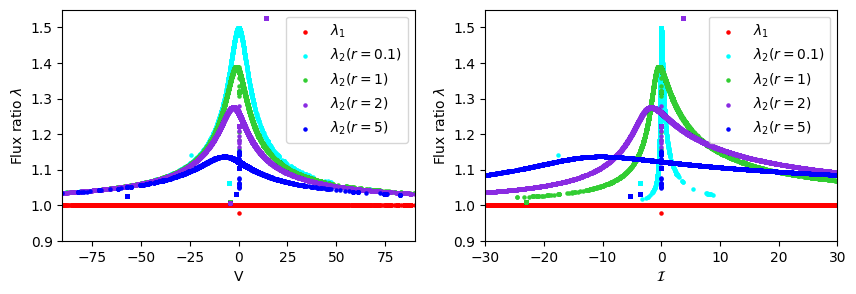

In [15]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

# First set of figures
axs[0, 0].scatter(V3_sol, lmd13, label='$\lambda_1$', s=5, color='red')
axs[0, 0].scatter(V_sol, lmd2, label='$\lambda_2(r=0.1)$', s=5, color='cyan')
axs[0, 0].set_xlabel('V')
axs[0, 0].set_ylabel('Flux ratio $\lambda$')
axs[0, 0].legend()
axs[0, 0].set_xlim(-90, 90)  # Adjust the x-axis limits
axs[0, 0].set_ylim(.9, 1.55)  # Adjust the y-axis limits

axs[0, 1].scatter(I3_sol, lmd13, label='$\lambda_1$', s=5, color='red')
axs[0, 1].scatter(I_sol, lmd2, label='$\lambda_2(r=0.1)$', s=5, color='cyan')
axs[0, 1].set_xlabel('$\mathcal{I}$')
axs[0, 1].set_ylabel('Flux ratio $\lambda$')
axs[0, 1].legend()
axs[0, 1].set_xlim(-30, 30)  # Adjust the x-axis limits
axs[0, 1].set_ylim(.9, 1.55)  # Adjust the y-axis limits

# Second set of figures
axs[0, 0].scatter(V2_sol, lmd22, label='$\lambda_2(r=1)$', s=5, color='limegreen')
axs[0, 1].scatter(I2_sol, lmd22, label='$\lambda_2(r=1)$', s=5, color='limegreen')
axs[0, 0].legend()
axs[0, 1].legend()

# Third set of figures
axs[0, 0].scatter(V3_sol, lmd23, label='$\lambda_2(r=2)$', s=5, color='blueviolet')
axs[0, 1].scatter(I3_sol, lmd23, label='$\lambda_2(r=2)$', s=5, color='blueviolet')
axs[0, 0].legend()
axs[0, 1].legend()

# Fourth set of figures
axs[0, 0].scatter(V4_sol, lmd24, label='$\lambda_2(r=5)$', s=5, color='blue')
axs[0, 1].scatter(I4_sol, lmd24, label='$\lambda_2(r=5)$', s=5, color='blue')
axs[0, 0].legend()
axs[0, 1].legend()

plt.show()